In [25]:
from pathlib import Path
import numpy as np
from ortools.sat.python import cp_model
from google.protobuf import text_format
import optuna

In [26]:

def import_model(filepath: Path) -> cp_model.CpModel:
    model = cp_model.CpModel()
    with filepath.open("r") as file:
        text_format.Parse(file.read(), model.Proto())
    return model


# Automatically load all models from the 'models' directory
def load_models(directory: str) -> list:
    # model_paths = Path(directory).rglob("*.pb")
    model_paths = [Path("models/model_proto_-84479006250281510.pb")]
    return [import_model(path) for path in model_paths]



In [27]:

models = load_models("models")

In [28]:

from abc import ABC, abstractmethod


class CpSatParameter(ABC):
    def __init__(self, name, default_value):
        self.name = name
        self._default_value = default_value

    @abstractmethod
    def sample(self, trial: optuna.Trial):
        pass

    def get_optuna_default(self) -> dict:
        return {self.name: self._default_value}
    
    def get_cpsat_default(self):
        return self._default_value
    
    def get_cpsat_params(self, optuna_params):
        return {self.name: optuna_params[self.name]}
    
    def get_optuna_params(self, cpsat_params):
        return {self.name: cpsat_params[self.name]}

class BoolParameter(CpSatParameter):
    def __init__(self, name, default_value):
        super().__init__(name, default_value)

    def sample(self, trial: optuna.Trial):
        return trial.suggest_categorical(self.name, [True, False])

class CategoryParameter(CpSatParameter):
    def __init__(self, name, default_value, values):
        super().__init__(name, default_value)
        self.values = values

    def sample(self, trial: optuna.Trial):
        return trial.suggest_categorical(self.name, self.values)

class IntParameter(CpSatParameter):
    def __init__(self, name, default_value, lb, ub, log: bool):
        super().__init__(name, default_value)
        self.lower_bound = lb
        self.upper_bound = ub
        self.log = log

    def sample(self, trial: optuna.Trial):
        return trial.suggest_int(self.name, low = self.lower_bound, high= self.upper_bound, log = self.log)
    
class ListParameter(CpSatParameter):
    def __init__(self, name, default_value, values):
        super().__init__(name, default_value)
        self.values = values

    def sample(self, trial: optuna.Trial):
        sampled_list = []
        for value in self.values:
            select = trial.suggest_categorical(f"{self.name}:{value}", [True, False])
            if select:
                sampled_list.append(value)
        return sampled_list
    
    
    def get_optuna_default(self) -> dict:
        return {f"{self.name}:{value}": value in self._default_value for value in self.values}
    
    def get_cpsat_params(self, optuna_params):
        return {self.name: tuple(value for value in self.values if optuna_params[f"{self.name}:{value}"])}
    
    def get_optuna_params(self, cpsat_params):
        return {f"{self.name}:{value}": value in cpsat_params[self.name] for value in self.values}

    

    

    
class IntFromOrderedListParameter(CpSatParameter):
    """
    A mixture of categorical and integer parameter. The parameter has to be from
    a list of values, but the order has a semantic meaning, meaning that entry 1 is
    semantically between 0 and 2, etc. Separating this from a categorical parameter
    allows Optuna to make assumptions about the order of the values.

    CAVEAT: The default value has to be the index of the value in the list, not the value itself.
    """
    def __init__(self, name, default_value, values):
        super().__init__(name, default_value)
        self.values = values

    def sample(self, trial: optuna.Trial):
        return self.values[trial.suggest_int(self.name, low = 0, high= len(self.values)-1)]
    
    def get_optuna_default(self):
        return {self.name: self._default_value}
    
    def get_cpsat_default(self):
        return self.values[self._default_value]
    
    def get_cpsat_param(self, optuna_param):
        return self.values[optuna_param]
    
    def get_optuna_param(self, cpsat_param):
        return self.values.index(cpsat_param)


class CpSatParameterSpace:
    """
    Defines the hyperparameter space for the CP-SAT solver to be optimized by Optuna.

    The parameters are currently not too well chosen, as this is still the prototype.
    Based on empirical testing, the selection should be refined.
    """
    parameter_space = [
        BoolParameter(name="use_lns_only", default_value=False),
        BoolParameter(name="repair_hint", default_value=False),
        BoolParameter(name="use_lb_relax_lns", default_value=False),
        IntFromOrderedListParameter(name="preferred_variable_order", default_value=0, values=[0, 1, 2]),
        BoolParameter(name="use_erwa_heuristic", default_value=False),
        IntFromOrderedListParameter(name="linearization_level", default_value=1, values=[0, 1, 2]),
        CategoryParameter(name="fp_rounding", default_value=3, values=[0, 1, 3, 2]),
        BoolParameter(name="randomize_search", default_value=False),
        BoolParameter(name="diversify_lns_params", default_value=False),
        BoolParameter(name="add_objective_cut", default_value=False),
        BoolParameter(name="use_objective_lb_search", default_value=False),
        BoolParameter(name="use_objective_shaving_search", default_value=False),
        CategoryParameter(name="search_branching", default_value=0, values=[0, 1, 2, 3, 4, 5, 6, 7, 8]),
        IntFromOrderedListParameter(name="cut_level", default_value=1, values=[0, 1]),
        IntFromOrderedListParameter(name="max_all_diff_cut_size", default_value=1, values=[32, 64, 128]),
        IntFromOrderedListParameter(name="symmetry_level", default_value=2, values=[0, 1, 2]),
        # Controls the maximum number of iterations the presolve phase will execute. Fewer iterations can lead to faster presolve times but may result in less simplification of the problem.
        IntFromOrderedListParameter(name="max_presolve_iterations", default_value=2, values=[1, 2, 3, 5, 10]),
        # Sets the level of effort for probing during presolve. Lower levels reduce the time spent on probing but may leave more complex structures in the problem.
        IntFromOrderedListParameter(name="cp_model_probing_level", default_value=2, values=[0, 1, 2]),
        # Limits the deterministic time allocated for probing during presolve. Adjusting this can prevent excessive time consumption in the presolve phase.
        IntFromOrderedListParameter(name="presolve_probing_deterministic_time_limit", default_value=4, values=[0.1, 1.0, 5.0, 10.0, 30.0]),
        # Sets the threshold for bounded variable elimination (BVE) during presolve. Lower thresholds can speed up presolve but might result in less effective elimination of redundant variables.
        IntFromOrderedListParameter(name="presolve_bve_threshold", default_value=1, values=[100, 500, 1000]),
        ListParameter(name="ignore_subsolvers", default_value = [], values = ["default_lp", "fixed", "no_lp", "max_lp", "pseudo_costs", "reduced_costs", "quick_restart", "quick_restart_no_lp", "lb_tree_search", "probing"])
    ]
    def __init__(self, max_difference_to_default: int = -1):
        self.fixed_parameters = {}
        self.tunable_parameters = {param.name: param for param in self.parameter_space}
        self.max_difference_to_default = max_difference_to_default

    def fix_parameter(self, parameter: str, value = None):
        """
        Will fix a parameter. If the value is None, the default of CP-SAT will be used.
        The value must be for CP-SAT, not for Optuna.
        """
        self.tunable_parameters.pop(parameter, None)
        if value is not None:
            self.fixed_parameters[parameter] = value

    def sample(self, trial: optuna.Trial|optuna.trial.FixedTrial|dict|None, solver: cp_model.CpSolver|None = None) -> cp_model.CpSolver:
        """
        Returns a configured CP-SAT solver for a trial by Optuna. If no trial is given, the default solver is returned.
        """
        solver = cp_model.CpSolver() if solver is None else solver
        for parameter, value in self.fixed_parameters.items():
            setattr(solver.parameters, parameter, value)
        if trial is None:
            return solver
        num_different = 0
        if isinstance(trial, dict):
            trial = optuna.trial.FixedTrial(trial)
        for parameter in self.tunable_parameters.values():
            if parameter.name not in self.fixed_parameters:
                value = parameter.sample(trial)
                if value != parameter.get_cpsat_default():
                    num_different += 1
                    if self.max_difference_to_default >= 0 and num_different > self.max_difference_to_default:
                        raise optuna.TrialPruned()
                value = parameter.sample(trial)
                if isinstance(value, list):
                    param_handle = getattr(solver.parameters, parameter.name).extend(value)
                else:
                    setattr(solver.parameters, parameter.name, parameter.sample(trial))
        return solver
    
    def get_default_params_for_optuna(self):
        """
        Returns the default parameters for Optuna. These values can be different to the values used by CP-SAT.
        """
        default_params = {}
        for param in self.tunable_parameters.values():
            default_params.update(param.get_optuna_default())
        return default_params
    
    def build_solver_for_params(self, cpsat_params: dict):
        solver = cp_model.CpSolver()
        for parameter, value in cpsat_params.items():
            setattr(solver.parameters, parameter, value)
        return solver
    
    def get_cpsat_params_from_trial(self, trial: optuna.trial.FixedTrial) -> dict:
        """
        Returns the parameters for CP-SAT from an Optuna trial. The values are not the Optuna values, but the CP-SAT values.
        """
        return {param_name: self.tunable_parameters[param_name].get_cpsat_param(optuna_param_value) for param_name, optuna_param_value in trial.params.items()}
    
    def get_cpsat_params_diff(self, trial: optuna.trial.FixedTrial|optuna.Trial) -> dict:
        """
        Returns the parameters that are different from the default.
        """
        params = {}
        for param in self.tunable_parameters.values():
            params.update(param.get_cpsat_params(trial.params))
        return params
        default_params = self.get_
        return {param_name: self.tunable_parameters[param_name].get_cpsat_param(optuna_param_value) for param_name, optuna_param_value in trial.params.items() if optuna_param_value != self.tunable_parameters[param_name].get_optuna_default()}
    
    def distance_to_default(self, trial: optuna.trial.FixedTrial) -> int:
        """
        Returns the number of parameters that are different from the default.
        This can be useful as we usually want to use as many default values as possible,
        as they are much better tested.
        """
        return len(self.get_cpsat_params_diff(trial))

In [29]:
from collections import defaultdict
from scipy.stats import ttest_rel
from scipy import stats

def confidence_intervals_do_not_overlap(list1, list2, confidence=0.95):
    def calculate_confidence_interval(data, confidence):
        n = len(data)
        mean = np.mean(data)
        sem = stats.sem(data)  # Standard error of the mean
        margin_of_error = sem * stats.t.ppf((1 + confidence) / 2., n-1)
        return mean, mean - margin_of_error, mean + margin_of_error

    # Calculate confidence intervals
    mean1, lower1, upper1 = calculate_confidence_interval(list1, confidence)
    mean2, lower2, upper2 = calculate_confidence_interval(list2, confidence)

    # Check if confidence intervals overlap
    if upper1 < lower2 or upper2 < lower1:
        return True
    else:
        return False


class Objective:
    def __init__(self, model: cp_model.CpModel, parameter_space: CpSatParameterSpace, direction: str = "maximize", obj_for_timeout: int = 0):
        if direction not in ("maximize", "minimize"):
            raise ValueError("Direction must be 'maximize' or 'minimize'")
        self.maximization = direction == "maximize"
        self.model = model
        self.parameter_space = parameter_space
        self.n_trials = 10
        self.max_trials = 30
        self.obj_for_timeout = 0
        self._baseline = []
        self._samples = defaultdict(list)

    def _solve(self, solver: cp_model.CpSolver):
        status = solver.solve(self.model)
        if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            return solver.objective_value * (1 if self.maximization else -1)
        else:
            return self.obj_for_timeout * (1 if self.maximization else -1)

    def compute_baseline(self):
        if not self._baseline:
            print("Computing baseline")
            solver = self.parameter_space.sample(None)
            values = [self._solve(solver) for _ in range(self.max_trials)]
            self._samples[frozenset()].extend(values)
            self._baseline = values
            print("Baseline:", values)
        return self._baseline
        
    def _get_key_from_trial(self, trial: optuna.Trial|optuna.trial.FixedTrial):
        return frozenset(self.parameter_space.get_cpsat_params_diff(trial).items())

    def __call__(self, trial: optuna.Trial):
        solver = self.parameter_space.sample(trial)
        baseline = self.compute_baseline()
        prune_if_below = min(baseline) - (max(baseline) - min(baseline))
        param_key = self._get_key_from_trial(trial)
        n_trials = self.n_trials
        if param_key in self._samples:
            n_trials = min(self.max_trials -len(self._samples[param_key]), self.n_trials)
            n_trials = max(n_trials, 0)
        for _ in range(n_trials):
            value = self._solve(solver)
            self._samples[param_key].append(value)
            if value < prune_if_below:
                raise optuna.TrialPruned()
        return float(np.mean(self._samples[param_key]))
    
    def evaluate_trial(self, trial: optuna.Trial|optuna.trial.FixedTrial):
        key = self._get_key_from_trial(trial)
        values = self._samples[key]
        baseline = self._samples[frozenset()]
        # test significance
        return np.mean(values)-np.mean(baseline), confidence_intervals_do_not_overlap(values, baseline)
    
    def best_params(self, max_changes: int = -1):
        keys_to_consider = [key for key in self._samples if max_changes<0 or len(key) <= max_changes]
        best_key = max(keys_to_consider, key=lambda x: np.mean(self._samples[x]))
        values = self._samples[best_key]
        baseline = self._samples[frozenset()]
        return best_key, np.mean(values)-np.mean(baseline), confidence_intervals_do_not_overlap(values, baseline)

In [30]:

def tune_for_quality_within_timelimit(model: cp_model.CpModel, timelimit_in_s: float, obj_for_timeout: int, direction: str):
    parameter_space = CpSatParameterSpace()
    parameter_space.fix_parameter("max_time_in_seconds", timelimit_in_s)
    objective = Objective(model, parameter_space, direction=direction,obj_for_timeout=obj_for_timeout)

    # Extract default parameter values to use in the initial trial
    default_params = parameter_space.get_default_params_for_optuna()
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
    study.enqueue_trial(default_params)

    study.optimize(objective, n_trials=100)

    best_params, diff_to_baseline, significant = objective.best_params()
    best_params = {key: value for key, value in best_params}
    print("The best parameters are:", best_params)
    print("The difference to the baseline is:", diff_to_baseline)
    print("This is significant:", significant)

    return best_params, diff_to_baseline, significant

tune_for_quality_within_timelimit(models[0], 1, 0, "maximize")


[I 2024-08-13 19:33:48,808] A new study created in memory with name: no-name-92485ea9-08ef-4c2f-8ae7-256b6796d387


Computing baseline
Baseline: [156463.0, 156871.0, 156731.0, 156753.0, 157002.0, 157161.0, 157082.0, 155588.0, 157145.0, 157087.0, 157002.0, 156860.0, 157161.0, 157145.0, 155544.0, 157161.0, 157002.0, 156756.0, 156312.0, 157145.0, 157316.0, 157002.0, 156862.0, 155625.0, 156881.0, 157157.0, 157161.0, 155902.0, 156669.0, 157145.0]


[I 2024-08-13 19:34:29,897] Trial 0 finished with value: 156947.1 and parameters: {'use_lns_only': False, 'repair_hint': False, 'use_lb_relax_lns': False, 'preferred_variable_order': 0, 'use_erwa_heuristic': False, 'linearization_level': 1, 'fp_rounding': 3, 'randomize_search': False, 'diversify_lns_params': False, 'add_objective_cut': False, 'use_objective_lb_search': False, 'use_objective_shaving_search': False, 'search_branching': 0, 'cut_level': 1, 'max_all_diff_cut_size': 1, 'symmetry_level': 2, 'max_presolve_iterations': 2, 'cp_model_probing_level': 2, 'presolve_probing_deterministic_time_limit': 4, 'presolve_bve_threshold': 1, 'ignore_subsolvers:default_lp': False, 'ignore_subsolvers:fixed': False, 'ignore_subsolvers:no_lp': False, 'ignore_subsolvers:max_lp': False, 'ignore_subsolvers:pseudo_costs': False, 'ignore_subsolvers:reduced_costs': False, 'ignore_subsolvers:quick_restart': False, 'ignore_subsolvers:quick_restart_no_lp': False, 'ignore_subsolvers:lb_tree_search': False, 

The best parameters are: {'randomize_search': False, 'use_erwa_heuristic': False, 'symmetry_level': 1, 'repair_hint': False, 'add_objective_cut': False, 'max_presolve_iterations': 1, 'use_objective_lb_search': False, 'cut_level': 0, 'use_lb_relax_lns': False, 'preferred_variable_order': 1, 'use_objective_shaving_search': False, 'presolve_probing_deterministic_time_limit': 1, 'fp_rounding': 2, 'linearization_level': 0, 'ignore_subsolvers': ('default_lp', 'fixed', 'max_lp'), 'max_all_diff_cut_size': 0, 'presolve_bve_threshold': 1, 'search_branching': 6, 'diversify_lns_params': False, 'use_lns_only': False, 'cp_model_probing_level': 1}
The difference to the baseline is: 516.3999999999942
This is significant: True


({'randomize_search': False,
  'use_erwa_heuristic': False,
  'symmetry_level': 1,
  'repair_hint': False,
  'add_objective_cut': False,
  'max_presolve_iterations': 1,
  'use_objective_lb_search': False,
  'cut_level': 0,
  'use_lb_relax_lns': False,
  'preferred_variable_order': 1,
  'use_objective_shaving_search': False,
  'presolve_probing_deterministic_time_limit': 1,
  'fp_rounding': 2,
  'linearization_level': 0,
  'ignore_subsolvers': ('default_lp', 'fixed', 'max_lp'),
  'max_all_diff_cut_size': 0,
  'presolve_bve_threshold': 1,
  'search_branching': 6,
  'diversify_lns_params': False,
  'use_lns_only': False,
  'cp_model_probing_level': 1},
 516.3999999999942,
 True)

In [31]:

fig = optuna.visualization.plot_param_importances(study)
fig.show()


NameError: name 'study' is not defined

In [ ]:

fig = optuna.visualization.plot_slice(study)#, params=["use_objective_shaving_search", "fp_rounding"])
fig.show()


In [ ]:
trial = study.best_trial

In [ ]:
count_params = {}
for trial in study.trials:
    fd = frozenset(trial.params.items())
    count_params[fd] = count_params.get(fd, 0) + 1
set(count_params.values())

{1, 2, 3, 4, 6, 13}

In [ ]:
from collections import defaultdict

trial_objs = defaultdict(list)
for trial in study.trials:
    fd = frozenset(trial.params.items())
    trial_objs[fd].append(trial.value)

for fd, objs in trial_objs.items():
    print(np.median(objs), max(objs), len(objs))

25.0 25.0 1
-82.5 -82.5 1
-310.5 -310.5 1
-113.0 -113.0 1
-964.5 -964.5 1
-677.0 -677.0 1
-234.5 -234.5 1
-590.5 -590.5 1
186.0 186.0 1
-1745.5 -1745.5 1
218.0 345.0 3
186.0 186.0 1
329.0 329.0 1
186.0 186.0 1
255.5 255.5 1
186.0 186.0 1
-1211.5 -1211.5 1
279.5 279.5 1
329.0 329.0 2
334.5 334.5 1
-716.5 -716.5 1
-2244.0 -2244.0 1
154.0 154.0 1
142.0 142.0 1
218.0 218.0 1
-4180.0 -4180.0 1
460.0 460.0 1
350.0 373.5 4
-5395.0 -5395.0 1
458.0 458.0 1
90.0 90.0 1
332.5 332.5 1
-73.0 -73.0 1
-1196.0 -1196.0 1
-17336.5 -17336.5 1
346.0 418.5 3
329.0 329.0 1
-1509.0 -1509.0 1
-608.5 -608.5 1
345.0 345.0 1
-130.0 -130.0 1
347.5 347.5 3
-1430.5 -1430.5 1
307.0 307.0 1
267.0 267.0 1
345.0 345.0 1
193.0 193.0 1
345.0 345.0 1
25.0 25.0 1
494.5 500.0 4
258.0 258.0 1
399.0 432.0 6
154.5 154.5 1
228.5 228.5 1
-15514.5 -15514.5 1
208.0 208.0 1
-519.5 -519.5 1
-208.5 -208.5 1
117.5 117.5 1
-726.5 -726.5 1
494.5 500.0 13
-27661.5 -27661.5 1
354.5 354.5 1
329.0 329.0 1
239.5 239.5 1
-858.0 -858.0 1
329.0

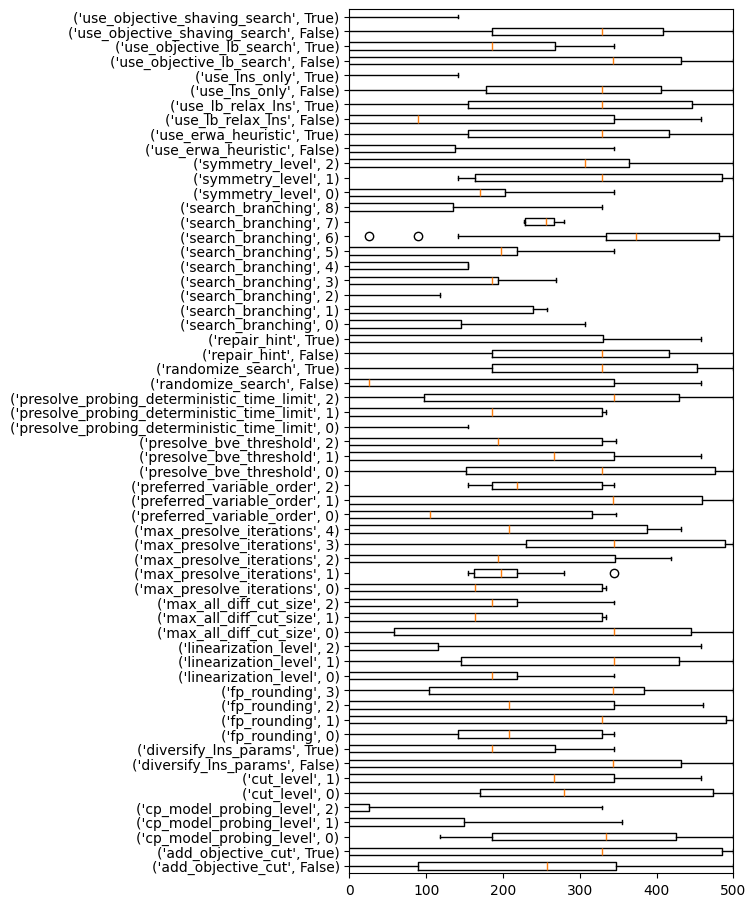

In [ ]:
# make boxplots for every parameter-value combination, showing the distribution of objective values
import matplotlib.pyplot as plt
from collections import defaultdict

objs_of_value = defaultdict(list)
for trial in study.trials:
    for param, value in trial.params.items():
        objs_of_value[(param, value)].append(trial.value)

# Sort the keys
sorted_keys = sorted(objs_of_value.keys())

# Extract the sorted values
sorted_values = [objs_of_value[key] for key in sorted_keys]

fig, ax = plt.subplots()
ax.boxplot(sorted_values, vert=False)  # Rotate the plot by 90 degrees
ax.set_yticklabels(sorted_keys)  # Set the sorted keys as y-tick labels

# Adjust the spacing to add more space between rows
plt.subplots_adjust(left=0.3, right=0.9, top=1.9, bottom=0.1)
plt.xlim(0, 500)
plt.show()